# Getting Started

This notebook gets you started with a brief nDCG evaluation with LensKit for Python with a simple experiment with the MovieLens 100K data set.

## Setup

We first need to install LensKit:

In [1]:
%pip install lenskit matplotlib scikit-learn scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Download the MovieLens data:

In [2]:
%%!
wget -q -O ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip

[]

In [3]:
#! unzip ml-100k.zip

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Now we can import LensKit utilities:

In [4]:
from lenskit.datasets import ML100K
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn
import sklearn.decomposition

And Pandas is very useful:

In [5]:
import pandas as pd

## Loading Data

We're going to use the ML-100K data set:

In [6]:
ml100k = ML100K('ml-100k')
ratings = ml100k.ratings
ratings.head()

,user,item,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [7]:
ml100k.users.head()

,age,gender,occupation,zip
user,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [8]:
ml100k.users.size

3772

In [9]:
ml100k.movies.head() # multi-hot encoding

,title,release,vidrelease,imdb,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
item,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Defining Algorithms

Let's set up two algorithms:

In [10]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

## Running the Evaluation

In LensKit, our evaluation proceeds in 2 steps:

1. Generate recommendations
2. Measure them

If memory is a concern, we can measure while generating, but we will not do that for now.

We will first define a function to generate recommendations from one algorithm over a single partition of the data set.  It will take an algorithm, a train set, and a test set, and return the recommendations.

**Note:** before fitting the algorithm, we clone it.  Some algorithms misbehave when fit multiple times.

**Note 2:** our algorithms do not necessarily implement the `Recommender` interface, so we adapt them. This fills in a default candidate selector.

The code function looks like this:

In [11]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

Now, we will loop over the data and the algorithms, and generate recommendations:

In [12]:
from lenskit import crossfold as xf
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

Numba is using threading layer omp - consider TBB
found 1 potential runtime problems - see https://boi.st/lkpy-perf


With the results in place, we can concatenate them into a single data frame:

In [13]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,1203,4.308836,3,1,ItemItem
1,1124,4.296551,3,2,ItemItem
2,1631,4.275189,3,3,ItemItem
3,488,4.272580,3,4,ItemItem
4,1449,4.260048,3,5,ItemItem


To compute our analysis, we also need to concatenate the test data into a single frame:

In [14]:
test_data = pd.concat(test_data, ignore_index=True)

In [15]:
test_data.size

60000

We analyze our recommendation lists with a `RecListAnalysis`.  It takes care of the hard work of making sure that the truth data (our test data) and the recoommendations line up properly.

We do assume here that each user only appears once per algorithm. Since our crossfold method partitions users, this is fine.

In [16]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
Algorithm user                 
ItemItem  3       100  0.000000
          9       100  0.066561
          11      100  0.068151
          18      100  0.209957
          37      100  0.037551

In [17]:
results.size

3772

Now we have nDCG values!

Normalized discounted cumulative gain is a measure of ranking quality. The value of NDCG is determined by comparing the relevance of the items returned by the search engine to the relevance of the item that a hypothetical “ideal” search engine would return.
Two assumptions are made in using DCG and its related measures.

   1. Highly relevant documents are more useful when appearing earlier in a search engine result list (have higher ranks)
   2. Highly relevant documents are more useful than marginally relevant documents, which are in turn more useful than non-relevant documents.

In [18]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.138222
ItemItem    0.102816
Name: ndcg, dtype: float64

Adn we can plot them:

<Axes: xlabel='Algorithm'>

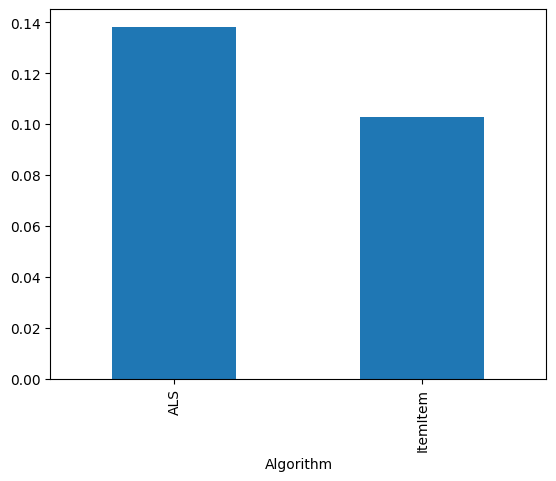

In [19]:
results.groupby('Algorithm').ndcg.mean().plot.bar()

## Algorithms comparison

In [20]:
# basic: 
from lenskit.algorithms.basic import PopScore, Popular, Random  # Recommend the most popular items. (or random)
# Popscore is a newer version of popular
from lenskit.algorithms.bias import Bias              # A user-item bias rating prediction algorithm.
from lenskit.algorithms.basic import Fallback         # The Fallback algorithm predicts with its first component,
                                                      # uses the second to fill in missing values, and so forth.

# KNN
from lenskit.algorithms.item_knn import ItemItem   # User-user nearest-neighbor collaborative filtering with ratings
from lenskit.algorithms.user_knn import UserUser   # Item-item nearest-neighbor collaborative filtering with ratings

# Matrix Factorization
from lenskit.algorithms.als import BiasedMF     # Biased matrix factorization trained with alternating least squares
from lenskit.algorithms.svd import BiasedSVD    # This code implements a traditional SVD using scikit-learn

In [21]:
# Recommend the most popular items.
algo_popular = Popular()
algo_popscore = PopScore()

# obvious
algo_random = Random()


# A user-item bias rating prediction algorithm. 
# The damping values can be interpreted as the number of default (mean) ratings to assume 
# a priori for each user or item, damping low-information users and items towards a mean 
# instead of permitting them to take on extreme values based on few ratings.

algo_bias = Bias() # damping = 0.0
algo_bias_low_damping = Bias(damping=0.01)
algo_bias_avg_damping = Bias(damping=0.2)
algo_bias_high_damping = Bias(damping=0.5)


# User-user nearest-neighbor collaborative filtering with ratings. 
# This user-user implementation is not terribly configurable; 
# it hard-codes design decisions found to work well in the previous Java-based LensKit code.

# Parameter: the maximum number of neighbors for scoring each item
algo_uu_5 = UserUser(5)
algo_uu_20 = UserUser(20)
algo_uu_80 = UserUser(80)


# Item-item nearest-neighbor collaborative filtering with ratings.
# This item-item implementation is not terribly configurable;
# it hard-codes design decisions found to work well in the previous Java-based LensKit code [ELKR11].
# This implementation is based on the description of item-based CF by Deshpande and Karypis [DK04],
# and produces results equivalent to Java LensKit.

# Prameter: --^
algo_ii_5 = ItemItem(5)
algo_ii_20 = ItemItem(20)
algo_ii_80 = ItemItem(80)


# This is a prediction-oriented algorithm suitable for explicit feedback data, 
# using the alternating least squares approach to compute and to minimize the
# regularized squared reconstruction error of the ratings matrix.

# Coordinate descent, adapted for a separately-trained bias model and to use weighted regularization
# as in the original ALS paper
algo_als_coord_desc10 = BiasedMF(10)
algo_als_coord_desc50 = BiasedMF(50)
# A direct implementation of the original ALS using LU-decomposition to solve for the optimized matrices.
algo_als_direct = BiasedMF(50, method='lu')


# Biased matrix factorization for implicit feedback using SciKit-Learn’s SVD solver.
# It operates by first computing the bias, then computing the SVD of the bias residuals.
algo_svd50 = BiasedSVD(50)
algo_svd100 = BiasedSVD(100)

In [22]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('Popular', algo_popular, train, test))
    all_recs.append(eval('PopScore', algo_popscore, train, test))
    all_recs.append(eval('Random', algo_random, train, test))
    all_recs.append(eval('Bias', algo_bias, train, test))
    all_recs.append(eval('BiasLowDamping', algo_bias_low_damping, train, test))
    all_recs.append(eval('BiasAvgDamping', algo_bias_avg_damping, train, test))
    all_recs.append(eval('BiasHighDamping', algo_bias_high_damping, train, test))
    all_recs.append(eval('UserUser5', algo_uu_5, train, test))
    all_recs.append(eval('UserUser20', algo_uu_20, train, test))
    all_recs.append(eval('UserUser80', algo_uu_80, train, test))
    all_recs.append(eval('ItemItem5', algo_ii_5, train, test))
    all_recs.append(eval('ItemItem20', algo_ii_20, train, test))
    all_recs.append(eval('ItemItem80', algo_ii_80, train, test))
    all_recs.append(eval('ALS10', algo_als_coord_desc10, train, test))
    all_recs.append(eval('ALS50', algo_als_coord_desc50, train, test))
    all_recs.append(eval('ALSDirect', algo_als_direct, train, test))
    all_recs.append(eval('SVD50', algo_svd50, train, test))
    all_recs.append(eval('SVD100', algo_svd100, train, test))

In [27]:
test_data = pd.concat(test_data, ignore_index=True)
all_recs = pd.concat(all_recs, ignore_index=True)

In [28]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
rla.add_metric(topn.precision)
rla.add_metric(topn.recall)
results = rla.compute(all_recs, test_data)
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS10              0.115529
ALS50              0.133014
ALSDirect          0.134891
Bias               0.074368
BiasAvgDamping     0.076634
BiasHighDamping    0.078676
BiasLowDamping     0.074410
ItemItem20         0.101167
ItemItem5          0.099711
ItemItem80         0.094475
PopScore           0.274417
Popular            0.274334
Random             0.029486
SVD100             0.149341
SVD50              0.155050
UserUser20         0.064810
UserUser5          0.070564
UserUser80         0.058167
Name: ndcg, dtype: float64

In [29]:
results.sort_values('ndcg', ascending=False).head()

nrecs      ndcg  precision    recall
Algorithm user                                      
Popular   265     100  0.765113       0.08  0.888889
PopScore  265     100  0.764835       0.08  0.888889
          895     100  0.750877       0.03  0.750000
Popular   895     100  0.750877       0.03  0.750000
SVD100    163     100  0.685449       0.03  0.600000

In [30]:
results.sort_values('precision', ascending=False).head()

nrecs      ndcg  precision    recall
Algorithm user                                      
PopScore  13      100  0.505055       0.54  0.425197
Popular   13      100  0.505306       0.54  0.425197
PopScore  276     100  0.601694       0.48  0.461538
Popular   276     100  0.594479       0.47  0.451923
          450     100  0.493176       0.45  0.416667

## Time for some graphics

<Axes: title={'center': 'NDCG'}, xlabel='Algorithm'>

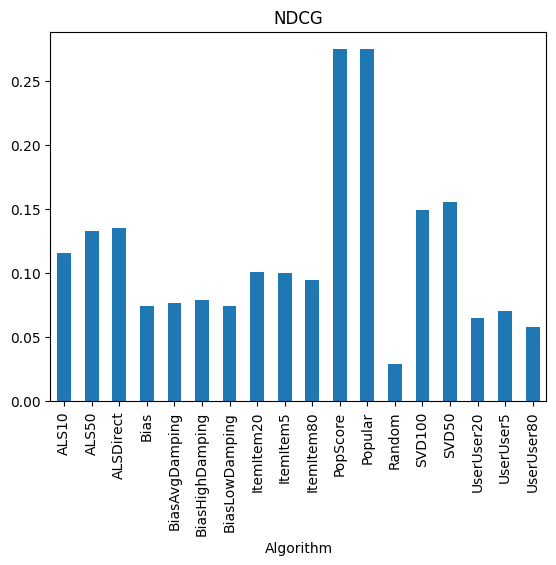

In [31]:
results.groupby('Algorithm').ndcg.mean().plot.bar(title='NDCG')

<Axes: title={'center': 'Precision'}, xlabel='Algorithm'>

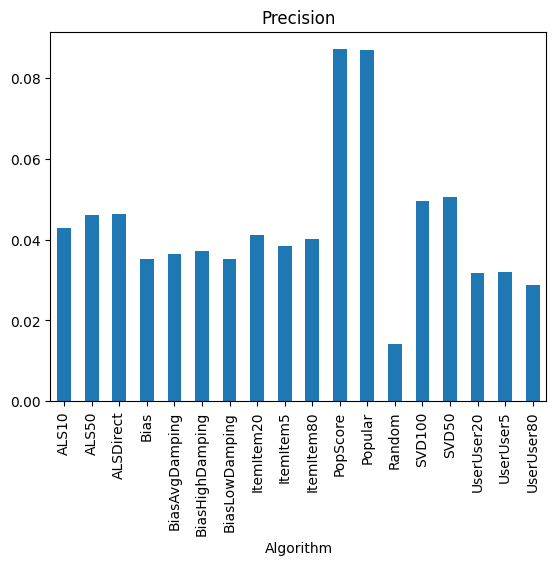

In [32]:
results.groupby('Algorithm').precision.mean().plot.bar(title='Precision')

<Axes: title={'center': 'Recall'}, xlabel='Algorithm'>

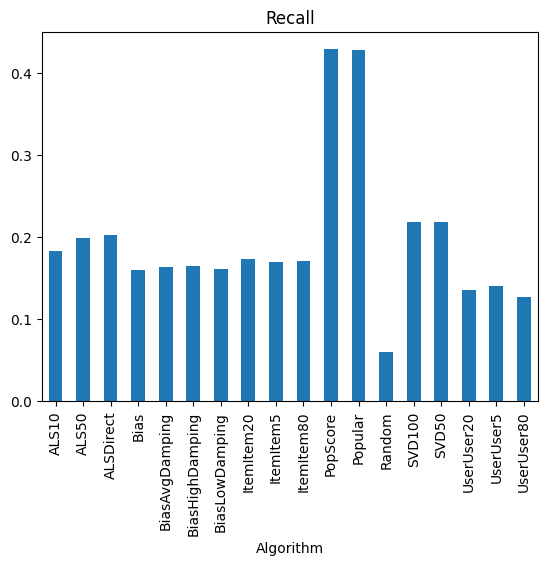

In [33]:
results.groupby('Algorithm').recall.mean().plot.bar(title='Recall')

## Time for some statistics

In [34]:
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

In [37]:
recs = all_recs.astype({'Algorithm': 'category'})
rec_algos = recs['Algorithm'].unique()
rec_algos

['Popular', 'PopScore', 'Random', 'Bias', 'BiasLowDamping', ..., 'ALS10', 'ALS50', 'ALSDirect', 'SVD50', 'SVD100']
Length: 18
Categories (18, object): ['ALS10', 'ALS50', 'ALSDirect', 'Bias', ..., 'SVD50', 'UserUser20', 'UserUser5', 'UserUser80']

We will now examine these metrics in more detail and test for statistical significance. Best practice for statistical testing for recommender systems is still a work in progress, but this method avoids most of the validity problems we know about.

The Friedman Chi-squared test will test the null hypothesis that there is no difference between algorithms in terms of their performance.

In [38]:
def metric_friedman(metric):
    groups = [df[metric] for a, df in results.groupby('Algorithm')]

    stat, p = friedmanchisquare(*groups)
    return pd.Series({'stat': stat, 'pvalue': p}, name=metric)

If the test detects significance, we have at least one pair of different algorithms - but which pairs? Unfortunately, the good tests aren't readily available in scipy and friends, so we're going to take a conservative approch and perform pairwise Wilconxon signed-rank tests with a Bonferroni adjustment.

In [39]:
pairs = pd.DataFrame.from_records(combinations(rec_algos, 2), columns=['A1', 'A2'])
def am_wilcox(metric, p_scale = len(pairs)):
    def compute(df):
        vs1 = results.loc[df['A1'], metric]
        vs2 = results.loc[df['A2'], metric]
        diff = (vs1 - vs2).mean()
        stat, p = wilcoxon(vs1, vs2)
        return pd.Series({'diff': diff, 'stat': stat, 'p': p, 'adj_p': p * p_scale})
    scores = pairs.apply(compute, axis=1)
    return pairs.join(scores)

In [40]:
metric_friedman('precision')

stat      6078.73057
pvalue       0.00000
Name: precision, dtype: float64

In [48]:
am_wilcox('precision').sort_values('diff', ascending=False).head(15)

/home/antony/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,A1,A2,diff,stat,p,adj_p
17,PopScore,Random,0.072969,202.0,2.817465e-147,4.310722e-145
1,Popular,Random,0.072927,204.0,4.145358e-147,6.342398e-145
24,PopScore,UserUser80,0.058399,2206.0,1.673634e-141,2.560660e-139
8,Popular,UserUser80,0.058356,2299.0,1.555492e-141,2.379903e-139
23,PopScore,UserUser20,0.055387,3199.5,4.831352e-140,7.391968e-138
7,Popular,UserUser20,0.055345,3283.0,6.381653e-140,9.763929e-138
22,PopScore,UserUser5,0.054984,3741.0,2.104500e-139,3.219885e-137
6,Popular,UserUser5,0.054942,3864.0,4.688590e-139,7.173542e-137
18,PopScore,Bias,0.051962,11245.0,1.143780e-128,1.749984e-126
19,PopScore,BiasLowDamping,0.051930,11069.5,1.490312e-128,2.280177e-126


In [42]:
metric_friedman('ndcg')

stat      7094.083532
pvalue       0.000000
Name: ndcg, dtype: float64

In [44]:
am_wilcox('ndcg').sort_values('diff', ascending=False).head(15)

,A1,A2,diff,stat,p,adj_p
17,PopScore,Random,0.244930,946.0,1.178311e-150,1.802815e-148
1,Popular,Random,0.244847,960.0,1.233208e-150,1.886809e-148
24,PopScore,UserUser80,0.216250,1296.0,2.513066e-150,3.844991e-148
8,Popular,UserUser80,0.216167,1324.0,4.025025e-150,6.158288e-148
23,PopScore,UserUser20,0.209607,1905.0,1.806880e-149,2.764526e-147
7,Popular,UserUser20,0.209524,1938.0,2.946652e-149,4.508378e-147
22,PopScore,UserUser5,0.203853,3764.0,2.241985e-147,3.430237e-145
6,Popular,UserUser5,0.203770,3822.0,3.980375e-147,6.089973e-145
18,PopScore,Bias,0.200049,5928.0,9.889401e-145,1.513078e-142
19,PopScore,BiasLowDamping,0.200007,5940.0,1.027117e-144,1.571489e-142


<Axes: title={'center': 'NDCG'}, xlabel='Algorithm'>

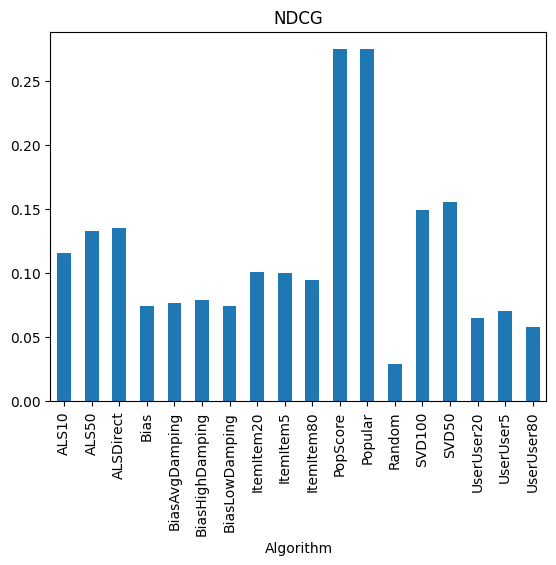

In [49]:
results.groupby('Algorithm').ndcg.mean().plot.bar(title='NDCG')

## User-user parameter fine-tuning

In [52]:
algo_uu_1 = UserUser(1)
algo_uu_5 = UserUser(5)
algo_uu_10 = UserUser(10)
algo_uu_15 = UserUser(15)

In [53]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('UserUser1', algo_uu_1, train, test))
    all_recs.append(eval('UserUser5', algo_uu_5, train, test))
    all_recs.append(eval('UserUser10', algo_uu_10, train, test))
    all_recs.append(eval('UserUser15', algo_uu_10, train, test))

In [54]:
test_data = pd.concat(test_data, ignore_index=True)
all_recs = pd.concat(all_recs, ignore_index=True)

In [55]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.groupby('Algorithm').ndcg.mean()

Algorithm
UserUser1     0.064963
UserUser10    0.068316
UserUser15    0.068316
UserUser5     0.069804
Name: ndcg, dtype: float64

<Axes: title={'center': 'NDCG'}, xlabel='Algorithm'>

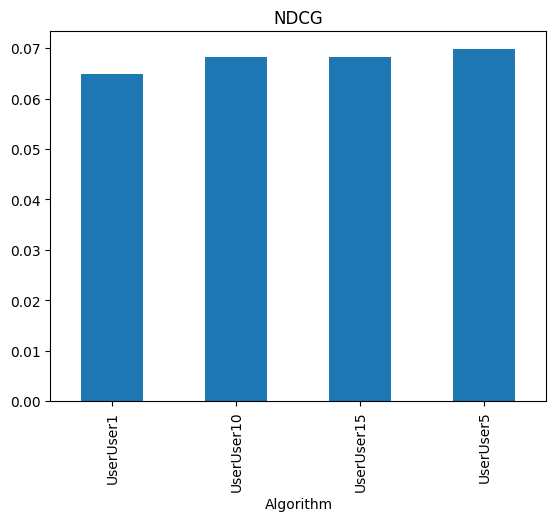

In [56]:
results.groupby('Algorithm').ndcg.mean().plot.bar(title='NDCG')

In [60]:
algo_uu_1 = UserUser(1)
algo_uu_2 = UserUser(2)
algo_uu_3 = UserUser(3)
algo_uu_4 = UserUser(4)
algo_uu_5 = UserUser(5)
algo_uu_6 = UserUser(6)
algo_uu_7 = UserUser(7)
algo_uu_8 = UserUser(8)
algo_uu_9 = UserUser(9)

In [61]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('UserUser1', algo_uu_1, train, test))
    all_recs.append(eval('UserUser2', algo_uu_2, train, test))
    all_recs.append(eval('UserUser3', algo_uu_3, train, test))
    all_recs.append(eval('UserUser4', algo_uu_4, train, test))
    all_recs.append(eval('UserUser5', algo_uu_5, train, test))
    all_recs.append(eval('UserUser6', algo_uu_6, train, test))
    all_recs.append(eval('UserUser7', algo_uu_7, train, test))
    all_recs.append(eval('UserUser8', algo_uu_8, train, test))
    all_recs.append(eval('UserUser9', algo_uu_9, train, test))

In [62]:
test_data = pd.concat(test_data, ignore_index=True)
all_recs = pd.concat(all_recs, ignore_index=True)

In [63]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.groupby('Algorithm').ndcg.mean()

Algorithm
UserUser1    0.065916
UserUser2    0.070265
UserUser3    0.071244
UserUser4    0.070117
UserUser5    0.070527
UserUser6    0.069718
UserUser7    0.069461
UserUser8    0.069000
UserUser9    0.068509
Name: ndcg, dtype: float64

<Axes: title={'center': 'NDCG'}, xlabel='Algorithm'>

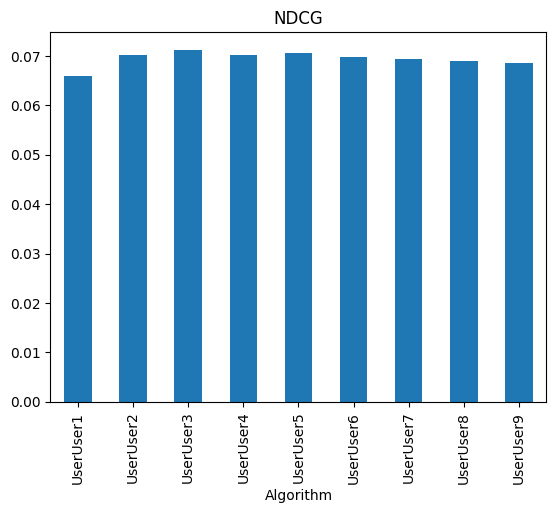

In [64]:
results.groupby('Algorithm').ndcg.mean().plot.bar(title='NDCG')

In [67]:
results.groupby('Algorithm').ndcg.mean().sort_values()  # winner: uu3

Algorithm
UserUser1    0.065916
UserUser9    0.068509
UserUser8    0.069000
UserUser7    0.069461
UserUser6    0.069718
UserUser4    0.070117
UserUser2    0.070265
UserUser5    0.070527
UserUser3    0.071244
Name: ndcg, dtype: float64